In [1]:
import os

import time
import progressbar
import warnings
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as utils
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from multiprocessing import cpu_count
from torch.multiprocessing import Pool

%matplotlib inline
plt.style.use('seaborn')

warnings.filterwarnings("ignore")
torch.set_num_threads(1)

In [2]:
# config
BATCH_SIZE = 32
EPOCH = 25
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def read_data_from_csv(path):
    df = pd.read_csv(path)
    X = df["sequence"].values
    y = df["label"].values
    return X, y

In [4]:
def load_train_val_test_data(level, analyze=True):
    data_base_path = "../data/hierarchy/" + level
    train_sequences, train_labels = read_data_from_csv(os.path.join(data_base_path, "train.csv"))
    val_sequences, val_labels = read_data_from_csv(os.path.join(data_base_path, "val.csv"))
    test_sequences, test_labels = read_data_from_csv(os.path.join(data_base_path, "test.csv"))
    
    if analyze:
        a = list(map(lambda x: len(x), train_sequences))
        print("DNA Sequence Length Statistics:")
        print("Max:", np.max(a))
        print("Min:", np.min(a))
        print("Mean:", np.ceil(np.mean(a)))
        print("Median:", np.ceil(np.median(a)))
        print("Sqrt of Max:", np.ceil(np.sqrt(np.max(a))))

    return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels

In [5]:
IMAGE_WIDTH = IMAGE_HEIGHT = 21  # 441 length zero-padded DNA sequences
IMAGE_CHANNELS = 4  # A, C, G, T

base_pair_map = {
    'A': [1, 0, 0, 0],
    'C': [0, 1, 0, 0],
    'G': [0, 0, 1, 0],
    'T': [0, 0, 0, 1],
    'X': [0, 0, 0, 0]
}

def seqeunces_to_image(sequences):
    image = np.zeros((len(sequences), IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
    for i, sequence in enumerate(sequences):
        for loc, base_pair in enumerate(sequence):
            row = loc // IMAGE_HEIGHT
            col = loc % IMAGE_HEIGHT
            image[i, row, col] = base_pair_map[base_pair]
    return image

In [6]:
# analyze sequences to get the image size
train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels = load_train_val_test_data("phylum")

DNA Sequence Length Statistics:
Max: 440
Min: 400
Mean: 422.0
Median: 423.0
Sqrt of Max: 21.0


In [7]:
base_pair_colors = {
    (1, 0, 0, 0): [183, 28, 28],  # red
    (0, 1, 0, 0): [174, 234, 0],  # green
    (0, 0, 1, 0): [0, 145, 234],  # blue
    (0, 0, 0, 1): [255, 111, 0],  # orange
    (0, 0, 0, 0): [33, 33, 33]   # black
}

base_pair_char = {
    (1, 0, 0, 0): "A",
    (0, 1, 0, 0): "C",
    (0, 0, 1, 0): "G",
    (0, 0, 0, 1): "T",
    (0, 0, 0, 0): "X"
}

def viz_dna_image(dna_image, log=False):
    w, h, _ = dna_image.shape
    dna_rgb_image = np.zeros((w, h, 3))
    dna_char_image = np.empty((w, h), dtype="U10")
    for i, row in enumerate(dna_image):
        for j, col in enumerate(row):
            dna_rgb_image[i][j] = base_pair_colors[tuple(col)]
            dna_char_image[i][j] = base_pair_char[tuple(col)]
    plt.grid(b=None)

    if log:
        print("DNA Sequence:\n", dna_char_image.flatten())
        print("DNA Block:\n", dna_char_image)
        print("DNA QRCode:")
    plt.imshow(dna_rgb_image/255.0)

In [8]:
def create_pytorch_datasets(data, labels):
    tensor_x = torch.stack([torch.Tensor(np.swapaxes(i, 0, 2)) for i in data]) # transform to torch tensors
    tensor_y = torch.stack([torch.Tensor([i]) for i in labels]).long().view(-1)

    dataset = utils.TensorDataset(tensor_x,tensor_y) # create your datset
    dataloader = utils.DataLoader(dataset, batch_size=BATCH_SIZE) # create your dataloader
    
    return dataloader

DNA Sequence:
 ['G' 'A' 'C' 'G' 'A' 'T' 'T' 'A' 'G' 'T' 'G' 'G' 'C' 'X' 'X' 'X']
DNA Block:
 [['G' 'A' 'C' 'G']
 ['A' 'T' 'T' 'A']
 ['G' 'T' 'G' 'G']
 ['C' 'X' 'X' 'X']]
DNA QRCode:


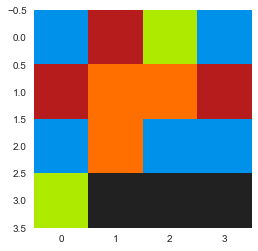

In [9]:
# Sample DNA Image Viz
sample_dna_sequence = "GACGATTAGTGGCXXX"  # 13bp length
dna_image = np.array([base_pair_map[c] for c in list(sample_dna_sequence)]).reshape(4, 4, 4)
viz_dna_image(dna_image, log=True)

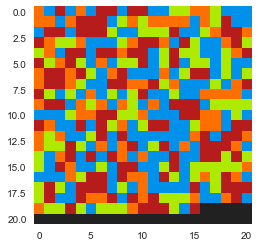

In [10]:
train_data = seqeunces_to_image(train_sequences)
viz_dna_image(train_data[0])

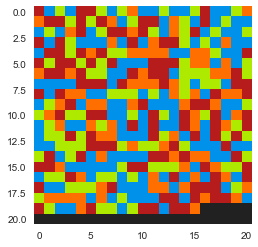

In [11]:
train_data = seqeunces_to_image(test_sequences)
viz_dna_image(train_data[0])

In [12]:
class SimpleCNN(nn.Module):

    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.fc1 = nn.Linear(16*32, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.pool1(self.conv2(x)))
        x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return(x)

class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(5*5*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = F.log_softmax(self.fc(out), dim=1)
        return out

In [13]:
# Print the CNN architecture
print(ConvNet(3))

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=800, out_features=3, bias=True)
)


In [14]:
def cnn_train_model(model, train_loader, test_loader, optimizer, EPOCH):
    model = model.to(DEVICE)

    if DEVICE == 'cuda':
        model = torch.nn.DataParallel(model)
        cudnn.benchmark = True

    t0 = time.perf_counter()

    loss_train = np.zeros((EPOCH,))
    loss_test = np.zeros((EPOCH,))
    acc_test = np.zeros((EPOCH,))
    acc_train = np.zeros((EPOCH,))
    time_test = np.zeros((EPOCH,))

    bar = progressbar.ProgressBar(min_value=1, max_value=EPOCH)
    for epoch in range(EPOCH):
        bar.update(epoch+1)

        # train 1 epoch
        model.train()
        correct = 0
        train_loss = 0
        for step, (x, y) in enumerate(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            b_x = Variable(x)
            b_y = Variable(y)
            scores = model(b_x)
            loss = F.nll_loss(scores, b_y)      # negative log likelyhood
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
            model.zero_grad()

            # computing training accuracy
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()
            train_loss += F.nll_loss(scores, b_y, reduction='sum').item()

        acc_train[epoch] = 100 * float(correct) / float(len(train_loader.dataset))
        loss_train[epoch] = train_loss / len(train_loader.dataset)

        # testing
        model.eval()
        correct = 0
        test_loss = 0
        for step, (x, y) in enumerate(test_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            b_x = Variable(x)
            b_y = Variable(y)
            scores = model(b_x)
            test_loss += F.nll_loss(scores, b_y, reduction='sum').item()
            pred = scores.data.max(1, keepdim=True)[1]
            correct += pred.eq(b_y.data.view_as(pred)).long().cpu().sum()

        loss_test[epoch] = test_loss/len(test_loader.dataset)
        acc_test[epoch] = 100 * float(correct) / float(len(test_loader.dataset))
        time_test[epoch] = time.perf_counter() - t0

    return [acc_train, acc_test, loss_train, loss_test]

In [15]:
def plot(acc_train, acc_test, loss_train, loss_test):
    print("Train Accuracy:", str(acc_train[-1]))
    print("Train Loss:", str(loss_train[-1]))
    print("Test Accuracy:", str(acc_test[-1]))
    print("Test Loss:", str(loss_test[-1]))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(acc_train, label='Acc. Train')
    plt.plot(acc_test, label='Acc. Test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss_train, label='Loss Train')
    plt.plot(loss_test, label='Loss Test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()
    plt.clf()

In [33]:
def cnn_train_eval(level, model, eval_on="test", cnn_config={"lr": 0.001, "weight_decay": 0}, is_plot=True):
    # load train-test data and convert to a PyTorch Dataset of QRCode images
    train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels = load_train_val_test_data(
        level, analyze=False)
    train_loader = create_pytorch_datasets(seqeunces_to_image(train_sequences), train_labels)
    if eval_on == "test":
        eval_loader = create_pytorch_datasets(seqeunces_to_image(test_sequences), test_labels)
    elif eval_on == "val":
        eval_loader = create_pytorch_datasets(seqeunces_to_image(val_sequences), val_labels)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=cnn_config["lr"], weight_decay=cnn_config["weight_decay"])
    logs = cnn_train_model(model, train_loader, eval_loader, optimizer, EPOCH)
    
    if is_plot:
        plot(*logs)

    output = logs + [cnn_config]
    print(output)

    return output

100% (25 of 25) |########################| Elapsed Time: 0:01:49 ETA:  00:00:00

Train Accuracy: 100.0
Train Loss: 4.7007488996483556e-05
Test Accuracy: 99.40054495912807
Test Loss: 0.017937882394816636


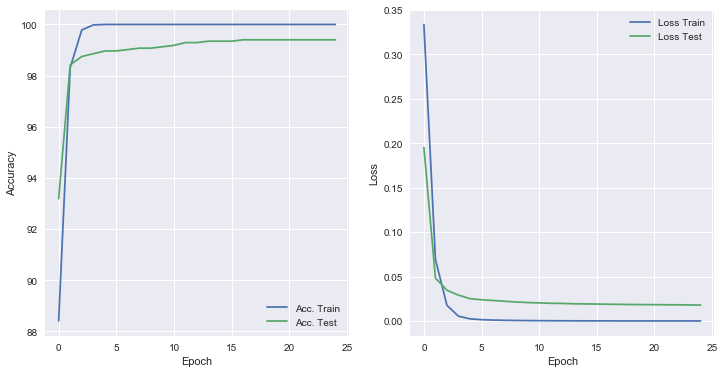

<Figure size 432x288 with 0 Axes>

In [17]:
cnn_train_eval("phylum", ConvNet(3))

100% (25 of 25) |########################| Elapsed Time: 0:01:48 ETA:  00:00:00

Train Accuracy: 100.0
Train Loss: 0.00019450910216154053
Test Accuracy: 98.52861035422343
Test Loss: 0.05099424344642286


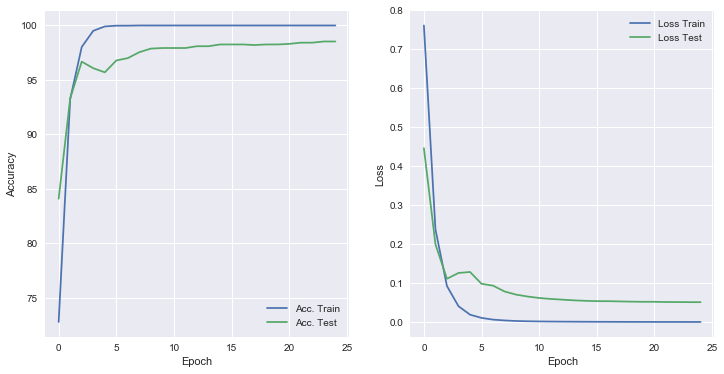

<Figure size 432x288 with 0 Axes>

In [18]:
cnn_train_eval("class", ConvNet(5))

100% (25 of 25) |########################| Elapsed Time: 0:01:47 ETA:  00:00:00

Train Accuracy: 100.0
Train Loss: 0.0008728189263925996
Test Accuracy: 94.22343324250681
Test Loss: 0.2399517126239288


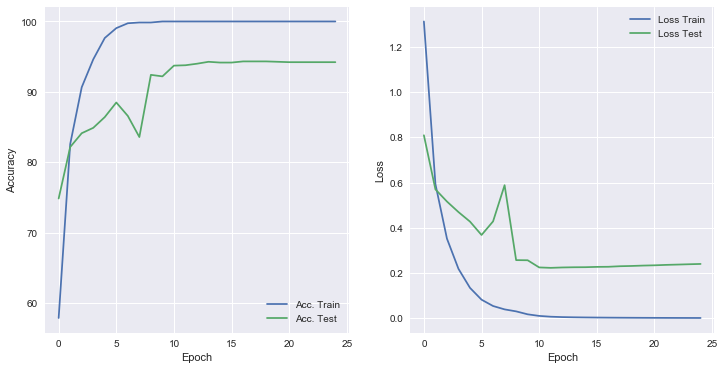

<Figure size 432x288 with 0 Axes>

In [19]:
cnn_train_eval("order", ConvNet(10))

In [20]:
# search space
levels_and_models = [("phylum", ConvNet(3)), ("class", ConvNet(5)), ("order", ConvNet(10))]
lr_space = np.geomspace(1e-6, 1e3, num=10)
weight_decay = np.geomspace(1e-6, 1e3, num=10)

In [21]:
# populate paramter dicts
param_dicts = list()
for model_id, (level, m) in enumerate(levels_and_models):
    for l in lr_space:
        for w in weight_decay:
            param_dict = {"level": level, "model": copy.deepcopy(m), "eval_on": "val", "cnn_config": {
                "model": model_id, "lr": l, "weight_decay": w}}
            param_dicts.append(param_dict)

In [ ]:
def cnn_train_test_unpack(args):
    return cnn_train_eval(**args)

with Pool(int(cpu_count() / torch.get_num_threads()) - 1) as p:
    experiment_logs = p.map(cnn_train_test_unpack, param_dicts)
np.save("data/grid_search_best_cnn_logs.npy", np.array(experiment_logs))

Train Accuracy: 32.848837209302324
Train Loss: 1.5473075363525124
Test Accuracy: 32.26158038147139
Test Loss: 1.5483619960192438


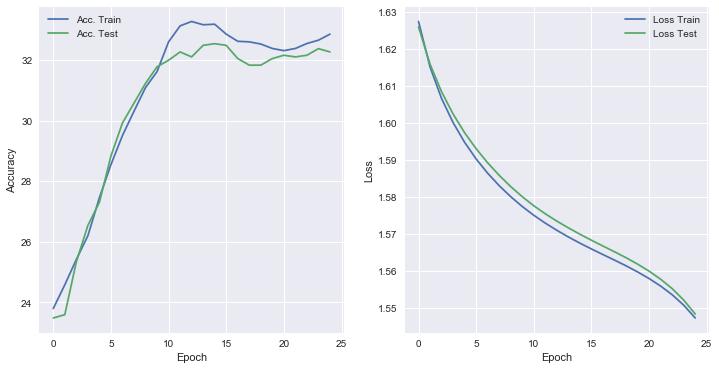

[array([23.80087209, 24.58212209, 25.41787791, 26.19912791, 27.45276163,
       28.54287791, 29.50581395, 30.30523256, 31.08648256, 31.61337209,
       32.59447674, 33.12136628, 33.26671512, 33.15770349, 33.17587209,
       32.84883721, 32.61264535, 32.59447674, 32.52180233, 32.37645349,
       32.30377907, 32.37645349, 32.53997093, 32.64898256, 32.84883721])
 array([23.48773842, 23.59673025, 25.34059946, 26.53950954, 27.30245232,
       28.82833787, 29.91825613, 30.57220708, 31.22615804, 31.77111717,
       31.98910082, 32.26158038, 32.09809264, 32.47956403, 32.53405995,
       32.47956403, 32.04359673, 31.82561308, 31.82561308, 32.04359673,
       32.15258856, 32.09809264, 32.15258856, 32.37057221, 32.26158038])
 array([1.62740275, 1.61511191, 1.60658352, 1.60007979, 1.59474625,
       1.5902582 , 1.58640621, 1.58304393, 1.58006567, 1.57741436,
       1.57504672, 1.57292581, 1.57098526, 1.56918886, 1.56752053,
       1.56594953, 1.56443214, 1.56293689, 1.56139866, 1.55975497,
       

<Figure size 432x288 with 0 Axes>

In [24]:
# try
experiment_logs = np.load("data/grid_search_best_cnn_logs.npy")
test_exp = 117
plot(*experiment_logs[test_exp][:-1])
print(experiment_logs[test_exp])

In [25]:
phylum_model, class_model, order_model = [[i for i in experiment_logs if i[4]["model"] == x] for x in [0, 1, 2]]

# sort based on best test accuracy
phylum_model = sorted(phylum_model, key=lambda x: x[1][-1], reverse=True)
class_model = sorted(class_model, key=lambda x: x[1][-1], reverse=True)
order_model = sorted(order_model, key=lambda x: x[1][-1], reverse=True)

In [34]:
top_n = 5

{'model': 0, 'lr': 0.01, 'weight_decay': 1e-06}
Train Accuracy: 100.0
Train Loss: 4.099032213521558e-06
Test Accuracy: 99.94550408719346
Test Loss: 0.0036661261108980516


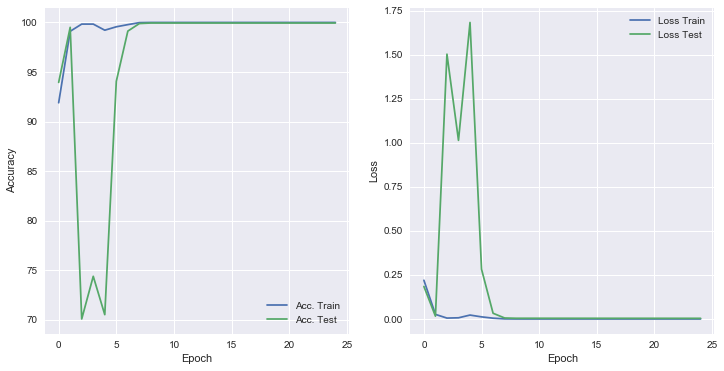

{'model': 0, 'lr': 0.01, 'weight_decay': 0.0001}
Train Accuracy: 100.0
Train Loss: 0.0001727176267047261
Test Accuracy: 99.89100817438693
Test Loss: 0.005138347194370197


<Figure size 432x288 with 0 Axes>

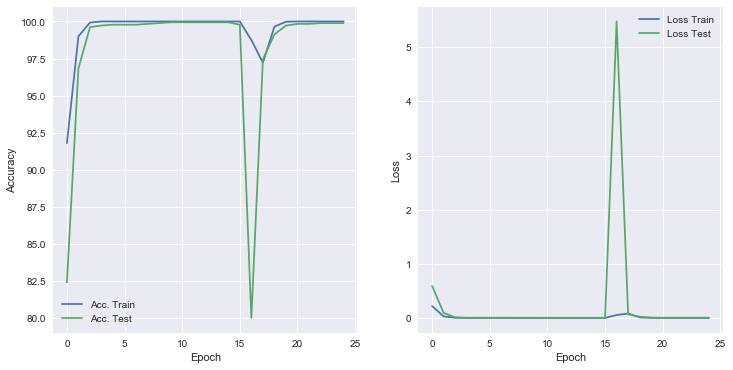

{'model': 0, 'lr': 0.001, 'weight_decay': 0.001}
Train Accuracy: 100.0
Train Loss: 0.00036104798836763516
Test Accuracy: 99.7275204359673
Test Loss: 0.008935328822694617


<Figure size 432x288 with 0 Axes>

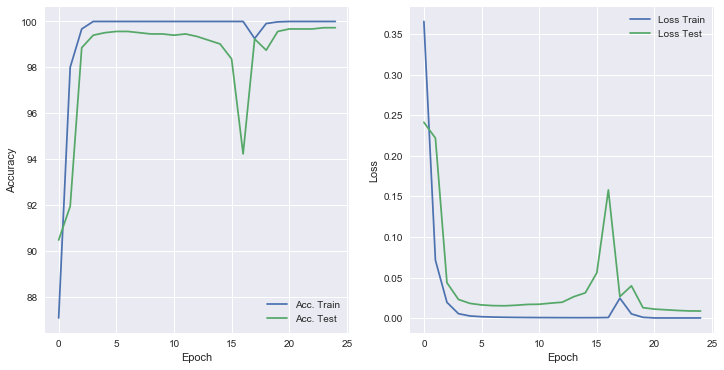

{'model': 0, 'lr': 0.01, 'weight_decay': 1e-05}
Train Accuracy: 100.0
Train Loss: 7.836537998776103e-06
Test Accuracy: 99.7275204359673
Test Loss: 0.006204425606480736


<Figure size 432x288 with 0 Axes>

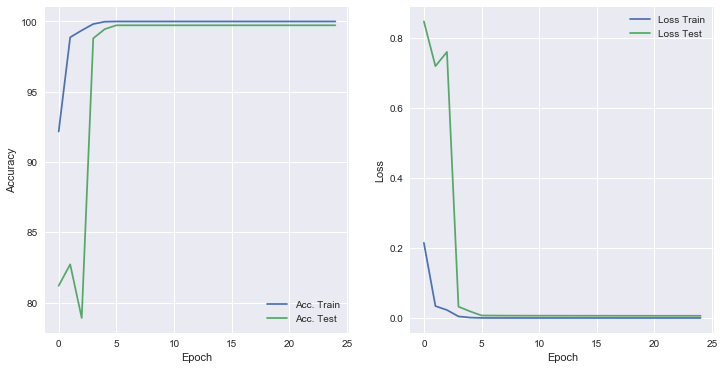

{'model': 0, 'lr': 0.001, 'weight_decay': 0.0001}
Train Accuracy: 100.0
Train Loss: 9.158877439277117e-05
Test Accuracy: 99.61852861035422
Test Loss: 0.013040821948558174


<Figure size 432x288 with 0 Axes>

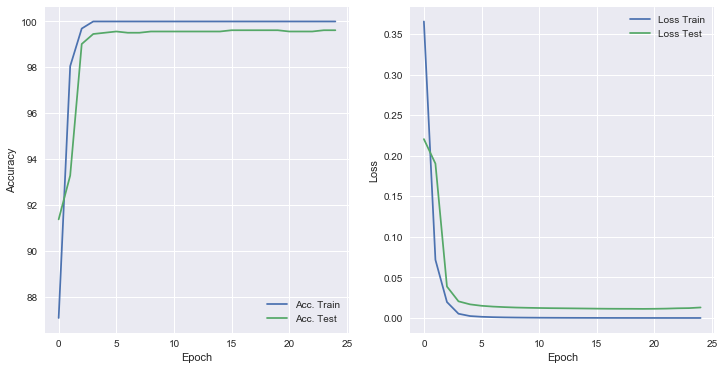

<Figure size 432x288 with 0 Axes>

In [35]:
for acc_train, acc_test, loss_train, loss_test, config in phylum_model[:top_n]:
    print(config)
    plot(acc_train, acc_test, loss_train, loss_test)

{'model': 1, 'lr': 0.01, 'weight_decay': 0.0001}
Train Accuracy: 100.0
Train Loss: 9.203546268995418e-05
Test Accuracy: 99.4550408719346
Test Loss: 0.023467805340114667


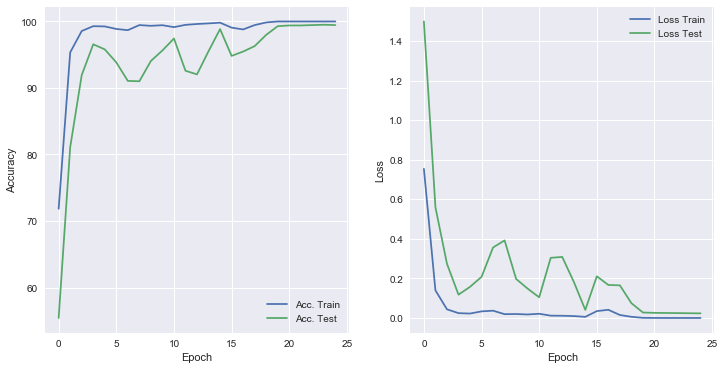

{'model': 1, 'lr': 0.01, 'weight_decay': 1e-06}
Train Accuracy: 100.0
Train Loss: 1.6747952200645624e-05
Test Accuracy: 99.23705722070845
Test Loss: 0.04325951555444369


<Figure size 432x288 with 0 Axes>

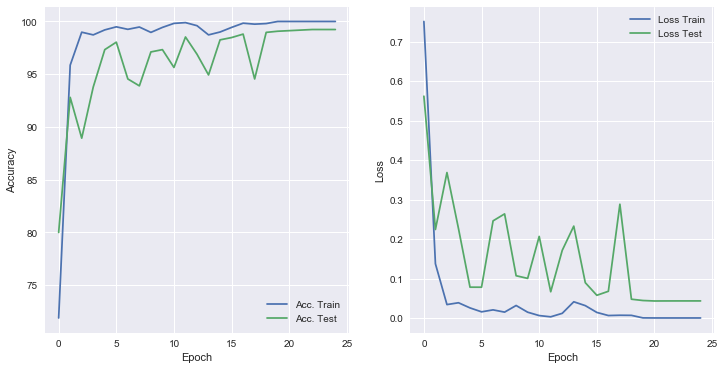

{'model': 1, 'lr': 0.001, 'weight_decay': 0.001}
Train Accuracy: 100.0
Train Loss: 0.0009181268166664035
Test Accuracy: 99.1825613079019
Test Loss: 0.022020277730125822


<Figure size 432x288 with 0 Axes>

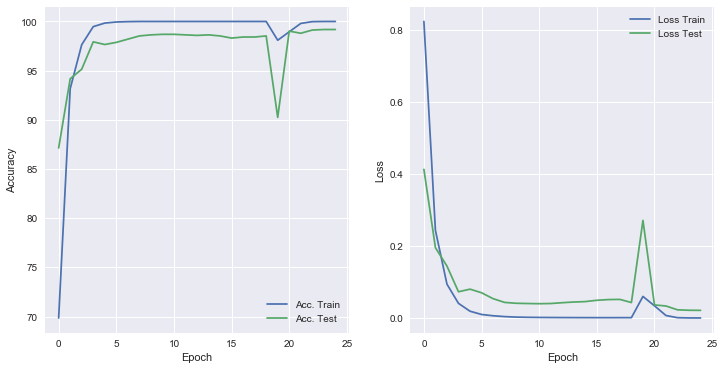

{'model': 1, 'lr': 0.001, 'weight_decay': 0.01}
Train Accuracy: 99.89098837209302
Train Loss: 0.01542015629279059
Test Accuracy: 98.96457765667574
Test Loss: 0.04392753206091941


<Figure size 432x288 with 0 Axes>

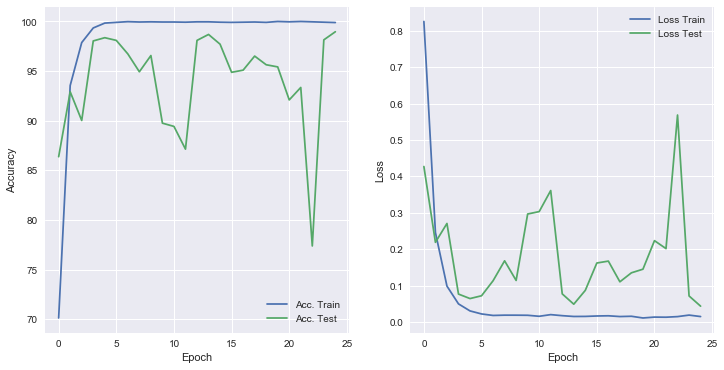

{'model': 1, 'lr': 0.001, 'weight_decay': 1e-06}
Train Accuracy: 100.0
Train Loss: 0.00018405095609121545
Test Accuracy: 98.91008174386921
Test Loss: 0.03270452207700433


<Figure size 432x288 with 0 Axes>

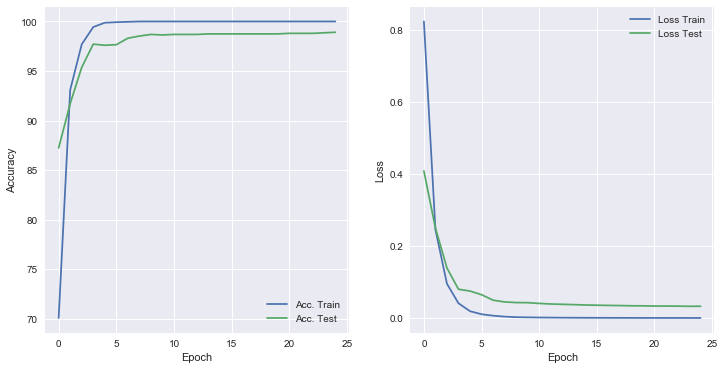

<Figure size 432x288 with 0 Axes>

In [36]:
for acc_train, acc_test, loss_train, loss_test, config in class_model[:top_n]:
    print(config)
    plot(acc_train, acc_test, loss_train, loss_test)

{'model': 2, 'lr': 0.01, 'weight_decay': 0.0001}
Train Accuracy: 100.0
Train Loss: 0.0004364191446193429
Test Accuracy: 94.55040871934605
Test Loss: 0.2662463108915074


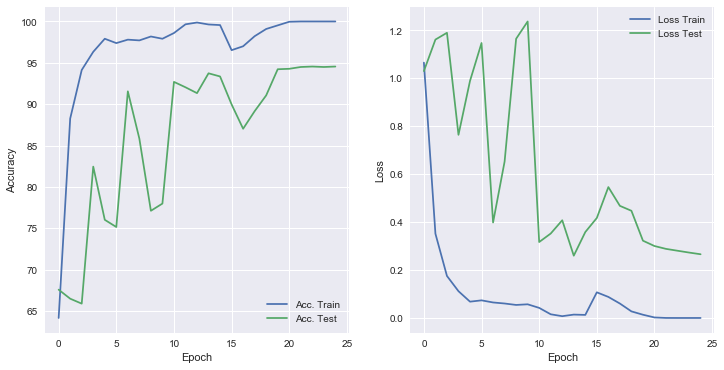

{'model': 2, 'lr': 0.001, 'weight_decay': 0.001}
Train Accuracy: 99.90915697674419
Train Loss: 0.011225902063902034
Test Accuracy: 94.27792915531334
Test Loss: 0.18268072942946847


<Figure size 432x288 with 0 Axes>

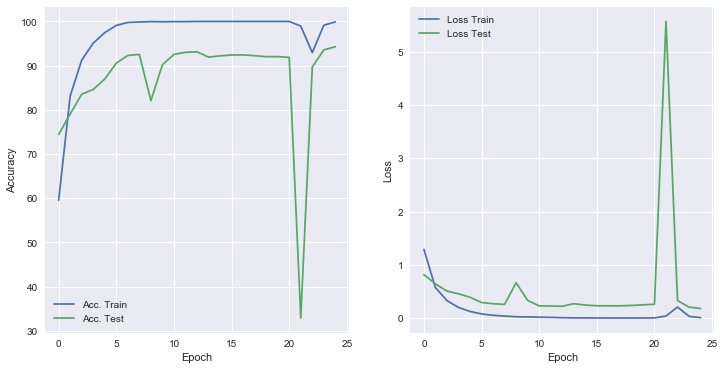

{'model': 2, 'lr': 0.01, 'weight_decay': 1e-05}
Train Accuracy: 100.0
Train Loss: 8.248061288234799e-05
Test Accuracy: 94.16893732970027
Test Loss: 0.27594940460995043


<Figure size 432x288 with 0 Axes>

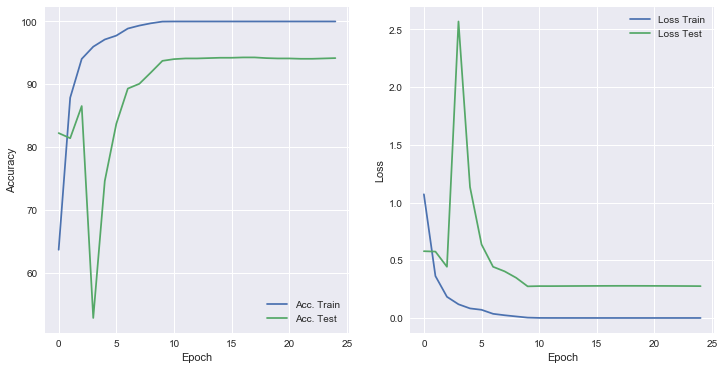

{'model': 2, 'lr': 0.001, 'weight_decay': 0.0001}
Train Accuracy: 100.0
Train Loss: 0.0010820851596288902
Test Accuracy: 93.7874659400545
Test Loss: 0.22943243437956723


<Figure size 432x288 with 0 Axes>

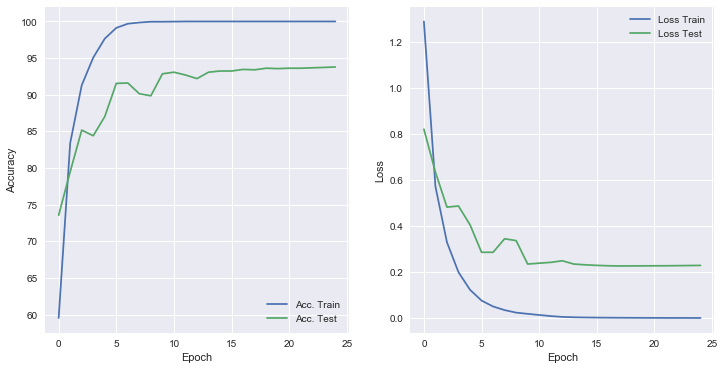

{'model': 2, 'lr': 0.001, 'weight_decay': 1e-05}
Train Accuracy: 100.0
Train Loss: 0.0008361590376427008
Test Accuracy: 93.62397820163488
Test Loss: 0.23820314998522765


<Figure size 432x288 with 0 Axes>

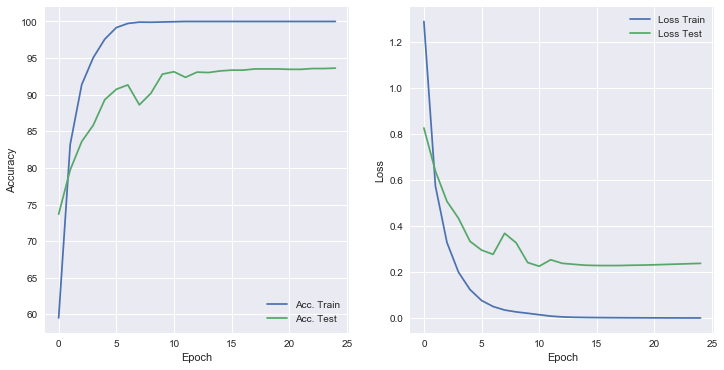

<Figure size 432x288 with 0 Axes>

In [37]:
for acc_train, acc_test, loss_train, loss_test, config in order_model[:top_n]:
    print(config)
    plot(acc_train, acc_test, loss_train, loss_test)